<a href="https://colab.research.google.com/github/theronitdey/molgenfinalproject2025/blob/main/MolGenFinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Molecular Genetics Final Project**

For my final project, I want to explore how deep learning models, traditionally thought to require massive datasets, can be adapted to small biological datasets through techniques such as data augmentation, transfer learning, and regularization. I want to tailor this towards creating a modelor distinguishing between acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL) using supervised learning techniques. I will first expand the effective size of the training set through biologically-informed data augmentation and pretraining strategies, and then develop a compact deep learning model (e.g., a small dense network or a Siamese network) optimized for generalization with minimal data. Rather than focusing on trying to maximize classification accuracy by using a very computationally intensive and complicated model architecture, I want to focus on computational efficiency and interpretability, since that is critical for practical applications in molecular genetics. On a personal level,  building computationally efficient and interpretable models is something I am passionate about and have experience with.

# Part 1: Setting up Imports and Reading in Data

In [1]:
#Various imports necessary to perform computations, develop supervised ML models, and create visualiztaions
import os
import numpy as np
import shutil
import pandas as pd
import tensorflow as tf
import matplotlib as plt
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix


from google.colab import drive
drive.mount('/content/drive') #Mounting to Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Reading in Data
train = pd.read_csv('/content/drive/MyDrive/MolGenFinal/AML Train Data Set.csv')
independent = pd.read_csv('/content/drive/MyDrive/MolGenFinal/AML Independent Data Set.csv')
actual = pd.read_csv('/content/drive/MyDrive/MolGenFinal/Actual.csv')

In [3]:
#Visualizing Data
print("\n Train head:")
print(train.head())

print("\n Actual labels head:")
print(actual.head())


 Train head:
                      Gene Description Gene Accession Number    1 call    2  \
0  AFFX-BioB-5_at (endogenous control)        AFFX-BioB-5_at -214    A -139   
1  AFFX-BioB-M_at (endogenous control)        AFFX-BioB-M_at -153    A  -73   
2  AFFX-BioB-3_at (endogenous control)        AFFX-BioB-3_at  -58    A   -1   
3  AFFX-BioC-5_at (endogenous control)        AFFX-BioC-5_at   88    A  283   
4  AFFX-BioC-3_at (endogenous control)        AFFX-BioC-3_at -295    A -264   

  call.1    3 call.2    4 call.3  ...   29 call.33   30 call.34   31 call.35  \
0      A  -76      A -135      A  ...   15       A -318       A  -32       A   
1      A  -49      A -114      A  ... -114       A -192       A  -49       A   
2      A -307      A  265      A  ...    2       A  -95       A   49       A   
3      A  309      A   12      A  ...  193       A  312       A  230       P   
4      A -376      A -419      A  ...  -51       A -139       A -367       A   

    32 call.36   33 call.37  


Based off what was generated from running the code, everything looks alright so far. We can see that there are corresponding rows and columns for both the "train" and "actual" data

# **Step 2: Data Processing**

In [4]:
# We want:
# - expression matrix (samples × genes)
# - matching labels

# Extract numeric columns (expression levels)
expression = train.iloc[:, 2:].select_dtypes(include=[np.number]).transpose()
expression.columns = train['Gene Description']

# Get sample labels (ALL → 0, AML → 1)
labels = actual['cancer'].map({'ALL': 0, 'AML': 1}).values

print("Expression matrix shape:", expression.shape)
print("Labels shape:", labels.shape)

Expression matrix shape: (38, 7129)
Labels shape: (72,)


In [5]:
#Next, I will perform data standardization

# Standardize to mean=0, std=1 — critical for deep learning!

scaler = StandardScaler()
X_scaled = scaler.fit_transform(expression)

In [6]:
#I will now perform a Dimensiopnality Reduction through Principal Component ANalysis (PCA)

# I want to reduce ~7000 genes into to ~30 principal components
# to avoid overfitting and capture major variation.

pca = PCA(n_components=30)
X_pca = pca.fit_transform(X_scaled)

print("PCA completed! Shape:", X_pca.shape)


PCA completed! Shape: (38, 30)


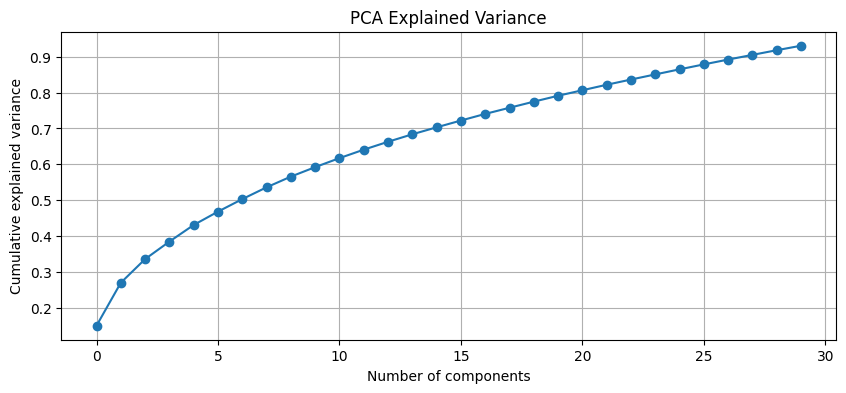

In [7]:
#Now, using MatPlotLib I will plot the variance explained by the PCA
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()


As you can see, by choosing 30 components for PCA, >90% of the variance in the data can be explained

In [8]:
#Now, we will perform data augmentations to add Gaussian noise in an attempt to simulate biological variability

def augment_data(X,y,noise_level=0.01,copies=2):
  X_aug = [X]
  y_aug = [y]

  for _ in range(copies):
    noise = np.random.normal(0, noise_level, X.shape)
    X_noisy = X + noise
    X_aug.append(X_noisy)
    y_aug.append(y)

  return np.vstack(X_aug), np.concatenate(y_aug)

# Safeguard: force overwrite to avoid duplication
X_aug, y_aug = augment_data(X_pca, labels.copy())

print("Data augmented. New shape:", X_aug.shape)


Data augmented. New shape: (114, 30)


In [10]:
#Finally, I will perform a traditional 80/20 split between training and testing data

X_train, X_test, y_train, y_test = train_test_split(
    X_aug, y_aug, test_size=0.2, random_state=42, stratify=y_aug)
print("Data split. Train shape:", X_train.shape, "Test shape:", X_test.shape)

ValueError: Found input variables with inconsistent numbers of samples: [114, 216]